<a href="https://colab.research.google.com/github/AlexKitipov/FractalNet/blob/main/FractalNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cartopy
import cartopy

In [2]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install pydot
import pydot

In [3]:
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

In [4]:
!apt-get -qq install -y libfluidsynth1

E: Package 'libfluidsynth1' has no installation candidate


In [5]:
!pip install matplotlib-venn

In [6]:
# Създай работна папка
!mkdir -p /content/FractalNet/fractalnet

# Премини в нея
%cd /content/FractalNet

/content/FractalNet


In [7]:
%%bash
set -e

# 1. Отиваме в работната папка (ако няма – се създава)
mkdir -p /content/FractalNet
cd /content/FractalNet

# 2. Пакетната конфигурация
cat << 'EOF' > setup.py
from setuptools import setup, find_packages

setup(
    name='fractalnet',
    version='0.1.0',
    description='Fractal Neural Network blocks for PyTorch',
    author='Твоето Име',
    packages=find_packages(),
    install_requires=['torch>=1.7.0'],
    python_requires='>=3.7'
)
EOF

# 3. Създаваме пакета и кода
mkdir -p fractalnet

cat << 'EOF' > fractalnet/blocks.py
import torch, random # Added torch import
import torch.nn as nn

class FractalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, depth, drop_rate=0.15):
        super().__init__()
        self.depth     = depth
        self.drop_rate = drop_rate

        if depth == 1:
            self.block = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        else:
            self.left  = FractalBlock(in_ch, out_ch, depth-1, drop_rate)
            self.right = FractalBlock(in_ch, out_ch, depth-1, drop_rate)

    def forward(self, x):
        if self.depth == 1:
            return self.block(x)

        # drop-path
        if self.training and random.random() < self.drop_rate:
            return self.left(x) if random.random()<0.5 else self.right(x)

        out_l = self.left(x)
        out_r = self.right(x)
        return 0.5 * (out_l + out_r)
EOF

cat << 'EOF' > fractalnet/model.py
import torch # Added torch import
import torch.nn as nn
from fractalnet.blocks import FractalBlock # Corrected import

class FractalNet(nn.Module):
    """
    A simplified implementation of the Fractal Network architecture.
    Based on "FractalNet: Ultra-Deep Neural Networks without Residuals"
    (https://arxiv.org/abs/1607.03817)
    """
    def __init__(self, num_classes=10, depth=3, drop_rate=0.15):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(16)
        self.relu  = nn.ReLU(inplace=True)
        self.block = FractalBlock(16, 32, depth, drop_rate) # Example usage, adjust channels as needed
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(32, num_classes) # Adjust in_features based on block output

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.block(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
EOF


# празен __init__.py
touch fractalnet/__init__.py

# 4. Инсталираме локално
pip install -e .

Obtaining file:///content/FractalNet
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: fractalnet
    Found existing installation: fractalnet 0.1.0
    Uninstalling fractalnet-0.1.0:
      Successfully uninstalled fractalnet-0.1.0
  Running setup.py develop for fractalnet


In [8]:
import torch
from fractalnet.blocks import FractalBlock

# Пример за тестване на FractalBlock
block = FractalBlock(in_ch=3, out_ch=16, depth=3)
x     = torch.randn(1, 3, 32, 32)
out   = block(x)
print("Фрактален блок:", block)
print("Форма на изхода:", out.shape)


Фрактален блок: FractalBlock(
  (left): FractalBlock(
    (left): FractalBlock(
      (block): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (right): FractalBlock(
      (block): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
  (right): FractalBlock(
    (left): FractalBlock(
      (block): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (right): FractalBlock(
      (block): Sequential(
        (0): Con

In [9]:
%run setup.py install

INFO:root:running install
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

       

In [10]:
!touch fractalnet/__init__.py

In [11]:
pip install -e .


DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/fractalnet-0.1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Obtaining file:///content/FractalNet
  Preparing metadata (setup.py) ... done
  Attempting uninstall: fractalnet
    Found existing installation: fractalnet 0.1.0
    Uninstalling fractalnet-0.1.0:
      Successfully uninstalled fractalnet-0.1.0
  Running setup.py develop for fractalnet


In [12]:
from fractalnet.model import FractalNet
import torch

model = FractalNet()
dummy_input = torch.randn(1, 3, 32, 32)
output = model(dummy_input)

print("Изходна форма:", output.shape)


Изходна форма: torch.Size([1, 10])


In [13]:
# ✅ Импортиране на всички нужни библиотеки
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from fractalnet.model import FractalNet  # Увери се, че пътят е верен

# 🔧 Настройка на трансформациите
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

# 📦 Зареждане на CIFAR-10
train_ds = datasets.CIFAR10(root='.', train=True, download=True, transform=transform)
test_ds = datasets.CIFAR10(root='.', train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2)

# 🧠 Инициализация на модела и оптимизатора
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FractalNet(num_classes=10, depth=3, drop_rate=0.15).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# 🚀 Трениране – 1 епоха
model.train()
running_loss = 0.0
for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)  # 🔥 Тук вече има torch импортиран
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if (i + 1) % 100 == 0:
        print(f"[Batch {i+1}/{len(train_loader)}] Loss: {running_loss / 100:.4f}")
        running_loss = 0.0

# ✅ Бърз тест за точност
model.eval()
correct = total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images).argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")


[Batch 100/391] Loss: 2.0703
[Batch 200/391] Loss: 1.8957
[Batch 300/391] Loss: 1.8075
Test Accuracy: 32.82%


In [14]:
import torch
from fractalnet.blocks import FractalBlock

# Създай един фрактален блок
block = FractalBlock(in_ch=3, out_ch=16, depth=3)
print(block)

# Пробно подаване на един “dummy” тензор
x = torch.randn(1, 3, 32, 32)
out = block(x)
print("Output shape:", out.shape)


FractalBlock(
  (left): FractalBlock(
    (left): FractalBlock(
      (block): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (right): FractalBlock(
      (block): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
  (right): FractalBlock(
    (left): FractalBlock(
      (block): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (right): FractalBlock(
      (block): Sequential(
        (0): Conv2d(3, 16, kerne

[Epoch 1] Loss: 1.8959 | Test Accuracy: 32.43%
[Epoch 2] Loss: 1.7233 | Test Accuracy: 35.98%
[Epoch 3] Loss: 1.6572 | Test Accuracy: 36.05%
[Epoch 4] Loss: 1.6158 | Test Accuracy: 39.54%
[Epoch 5] Loss: 1.5678 | Test Accuracy: 37.38%
[Epoch 6] Loss: 1.5326 | Test Accuracy: 37.30%
[Epoch 7] Loss: 1.5030 | Test Accuracy: 41.91%
[Epoch 8] Loss: 1.4893 | Test Accuracy: 32.11%
[Epoch 9] Loss: 1.4759 | Test Accuracy: 46.15%
[Epoch 10] Loss: 1.4648 | Test Accuracy: 43.83%
[Epoch 11] Loss: 1.4622 | Test Accuracy: 46.08%
[Epoch 12] Loss: 1.4478 | Test Accuracy: 43.97%
[Epoch 13] Loss: 1.4518 | Test Accuracy: 46.96%
[Epoch 14] Loss: 1.4489 | Test Accuracy: 43.94%
[Epoch 15] Loss: 1.4419 | Test Accuracy: 45.56%
[Epoch 16] Loss: 1.4313 | Test Accuracy: 41.59%
[Epoch 17] Loss: 1.4391 | Test Accuracy: 48.70%
[Epoch 18] Loss: 1.4279 | Test Accuracy: 40.55%
[Epoch 19] Loss: 1.4264 | Test Accuracy: 44.99%
[Epoch 20] Loss: 1.4367 | Test Accuracy: 46.84%
⏱️ Общо време: 4215.7 сек


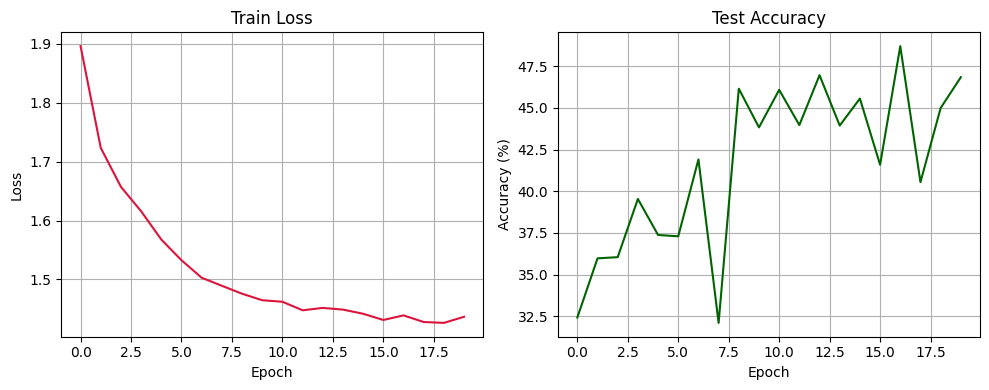

In [15]:
import time
import matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from fractalnet.model import FractalNet

# 1. Настройка на данните
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

train_ds = datasets.CIFAR10(root='.', train=True,  download=True, transform=transform)
test_ds  = datasets.CIFAR10(root='.', train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,  num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=2)

# 2. Модел, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = FractalNet(num_classes=10, depth=3, drop_rate=0.15).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

num_epochs = 20
train_losses = []
test_accs = []
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Evaluate
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total
    test_accs.append(acc)

    print(f"[Epoch {epoch+1}] Loss: {avg_loss:.4f} | Test Accuracy: {acc:.2f}%")

elapsed = time.time() - start_time
print(f"⏱️ Общо време: {elapsed:.1f} сек")

# Графики
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss', color='crimson')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(test_accs, label='Test Accuracy', color='darkgreen')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

In [16]:
from fractalnet.blocks import FractalBlock

In [17]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from fractalnet.model import FractalNet

# 1. Настройка на данните
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3),
])

train_ds = datasets.CIFAR10(root='.', train=True,  download=True, transform=transform)
test_ds  = datasets.CIFAR10(root='.', train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,  num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=2)

# 2. Модел, загуба и оптимизатор
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model     = FractalNet(num_classes=10, depth=3, drop_rate=0.15).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# 3. Трениране за повече епохи
num_epochs  = 50   # Може да зададете 50 или 100 за по-добра конвергенция
train_losses = []
test_accs    = []

start = time.time()
for epoch in range(1, num_epochs+1):
    # --- Training ---
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # --- Validation ---
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    acc = 100.0 * correct / total
    test_accs.append(acc)

    print(f"[Epoch {epoch:2d}/{num_epochs}] "
          f"Train Loss: {avg_loss:.4f} | Test Acc: {acc:5.2f}%")

elapsed = time.time() - start
print(f"\nОбщо време за трениране: {elapsed:.1f} сек.")


[Epoch  1/50] Train Loss: 1.9067 | Test Acc: 32.49%
[Epoch  2/50] Train Loss: 1.7258 | Test Acc: 37.19%
[Epoch  3/50] Train Loss: 1.6544 | Test Acc: 41.09%
[Epoch  4/50] Train Loss: 1.5931 | Test Acc: 40.70%
[Epoch  5/50] Train Loss: 1.5574 | Test Acc: 42.24%
[Epoch  6/50] Train Loss: 1.5214 | Test Acc: 41.24%
[Epoch  7/50] Train Loss: 1.5059 | Test Acc: 44.96%
[Epoch  8/50] Train Loss: 1.4963 | Test Acc: 46.22%
[Epoch  9/50] Train Loss: 1.4800 | Test Acc: 37.62%
[Epoch 10/50] Train Loss: 1.4717 | Test Acc: 44.32%
[Epoch 11/50] Train Loss: 1.4636 | Test Acc: 44.45%
[Epoch 12/50] Train Loss: 1.4668 | Test Acc: 46.69%
[Epoch 13/50] Train Loss: 1.4580 | Test Acc: 46.52%
[Epoch 14/50] Train Loss: 1.4491 | Test Acc: 43.87%
[Epoch 15/50] Train Loss: 1.4487 | Test Acc: 42.86%
[Epoch 16/50] Train Loss: 1.4397 | Test Acc: 43.35%
[Epoch 17/50] Train Loss: 1.4349 | Test Acc: 44.83%
[Epoch 18/50] Train Loss: 1.4355 | Test Acc: 43.33%
[Epoch 19/50] Train Loss: 1.4432 | Test Acc: 39.37%
[Epoch 20/50

In [18]:
from fractalnet.blocks import FractalBlock